### Hyper MNIST

#### Loading MNIST

In [1]:
import os
import torchvision
import torchvision.transforms as transforms
## load mnist dataset

root = 'data'
if not os.path.exists(root):
    os.mkdir(root)

trans = transforms.Compose([transforms.ToTensor()])
# if not exist, download mnist dataset
train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)


In [2]:
train_set[0][0].size()

torch.Size([1, 28, 28])

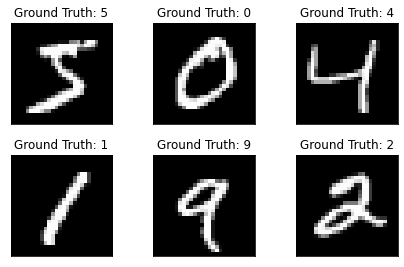

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_set[i][1]))
    plt.xticks([])
    plt.yticks([])

In [74]:
import torch

class TorchMNISTConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 512, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 10, 2, 2)
        )

    def forward(self, x):
        out = self.net(x).view(x.size(0), -1)
        return out

In [75]:
torch_target_network = TorchMNISTConvNet()
pytorch_total_params = sum(p.numel() for p in torch_target_network.parameters() if p.requires_grad)
pytorch_total_params

4745226

In [76]:
torch_target_network(torch.zeros(1,1,28,28)).size()

torch.Size([1, 10])

## Torch

In [77]:
from hypernn.torch.static_hypernet import TorchHyperNetwork
from typing import Any, Optional

### Simple Embedding Module + Weight Generator

### Instantiating hypernetwork with Class definitions

In [78]:
hypernetwork = TorchHyperNetwork.from_target(
    torch_target_network,
    embedding_dim=4,
    num_embeddings=1024
)

In [113]:
class RecursiveHyperNetwork(TorchHyperNetwork):
    def __init__(
        self,
        target_network: nn.Module,
        num_target_parameters: Optional[int] = None,
        embedding_dim: int = 100,
        num_embeddings: int = 3,
        hidden_dim: Optional[int] = None,
        *args, **kwargs
    ):
        super().__init__(
                    target_network = target_network,
                    num_target_parameters = num_target_parameters,
                    embedding_dim = embedding_dim,
                    num_embeddings = num_embeddings,
                    hidden_dim = hidden_dim,
                )

    def make_weight_generator(self):
        return nn.Linear(self.embedding_dim, self.hidden_dim, bias=False)

    def generate_params(
        self, inp = []
    ) -> Tuple[torch.Tensor, Dict[str, Any]]:
        embedding = self.embedding(torch.arange(self.num_embeddings).to(self.device))
        generated_params = torch.tanh(self.weight_generator(embedding).view(-1))
        return generated_params, {"embedding": embedding}


In [114]:
def hyper_hyper(num_levels: int, target_network, embedding_dim, num_embeddings):
    t = target_network
    for i in range(num_levels - 1):
        hypernetwork = RecursiveHyperNetwork.from_target(
                    t,
                    embedding_dim=embedding_dim,
                    num_embeddings=num_embeddings
        )
        t = hypernetwork
    hypernetwork = RecursiveHyperNetwork.from_target(
                t,
                embedding_dim=4,
                num_embeddings=num_embeddings
    )
    return hypernetwork

In [149]:
class HyperHyper(nn.Module):
    def __init__(self, num_levels, target_network, embedding_dim, num_embeddings):
        super().__init__()
        self.num_levels = num_levels
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.hypernetwork = hyper_hyper(num_levels, target_network, embedding_dim, num_embeddings)

    def forward(self, x):
        inp = x.to(self.hypernetwork.device)
        for i in range(self.num_levels - 1):
                inp = [inp]
        return self.hypernetwork(inp=[inp])

In [177]:
hypernetwork = HyperHyper(5, torch_target_network, 8, 72)

In [178]:
pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
pytorch_total_params

368

In [160]:
hypernetwork(torch.zeros((1,1,28,28)))

tensor([[ 0.0036,  0.0044, -0.0040,  0.0044, -0.0131,  0.0022, -0.0040, -0.0288,
          0.0086,  0.0031]], grad_fn=<ViewBackward0>)

In [161]:
device = torch.device("cuda")
hypernetwork = hypernetwork.to(device)

In [162]:
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=32,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=32,
                shuffle=False)

#### Train hypernetwork

In [164]:
import os
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

def get_tensorboard_logger(
    experiment_name: str, base_log_path: str = "tensorboard_logs"
):
    log_path = "{}/{}_{}".format(base_log_path, experiment_name, datetime.now())
    train_writer = SummaryWriter(log_path, flush_secs=10)
    full_log_path = os.path.join(os.getcwd(), log_path)
    print(
        "Follow tensorboard logs with: python -m tensorboard.main --logdir '{}'".format(full_log_path)
    )
    return train_writer

In [179]:
def random_sample(dataset, num_samples:int = 1):
    length = len(dataset)
    random_indices = np.random.randint(0,length, num_samples)
    return torch.stack([dataset[idx][0] for idx in random_indices]), torch.tensor([dataset[idx][1] for idx in random_indices])


import tqdm
import numpy as np

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=32,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=32,
                shuffle=False)

writer = get_tensorboard_logger("HypernetworkTorchRL")

hypernetwork = HyperHyper(5, torch_target_network, 4, 64)

optimizer = torch.optim.Adam(hypernetwork.parameters(), lr=0.001)
bar = tqdm.tqdm(np.arange(1000))

for i in bar:

    train_loss = []
    x, target = random_sample(train_set, 32)
    x = x.to(device)
    target = target.to(device)
    # for batch_idx, (x, target) in enumerate(train_loader):
    # for sample in samples:
    optimizer.zero_grad()
    inp = x.to(device)
    out = hypernetwork(inp)
    loss =  torch.nn.functional.cross_entropy(out.to(device), target.to(device))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(hypernetwork.parameters(), 10.0)
    optimizer.step()

    train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)

    grad_dict = {}
    for n, W in hypernetwork.named_parameters():
        if W.grad is not None:
            grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

    metrics = {"loss":loss.item(), **grad_dict}

    for key in metrics:
        writer.add_scalar(key, metrics[key], i)

    num_correct = 0
    count = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        count += x.size(0)
        with torch.no_grad():
            out = hypernetwork(x.to(device))
            _, predicted = torch.max(out.detach(), -1)
        num_correct += (predicted.detach().cpu() == target.data).sum()
    accuracy = num_correct / count

    grad_dict = {}
    for n, W in hypernetwork.named_parameters():
        if W.grad is not None:
            grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

    metrics = {"loss":loss.item(), "accuracy":accuracy.item(), **grad_dict}

    for key in metrics:
        writer.add_scalar(key, metrics[key], i)

    bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))


Follow tensorboard logs with: python -m tensorboard.main --logdir '/home/shyam/Code/hyper-nn/notebooks/tensorboard_logs/HypernetworkTorchRL_2022-04-26 17:06:53.438081'


Loss: 0.9432039260864258, Test Acc: 0.6363000273704529: 100%|██████████| 1000/1000 [5:59:45<00:00, 21.59s/it]  


#### Display subset of predictions

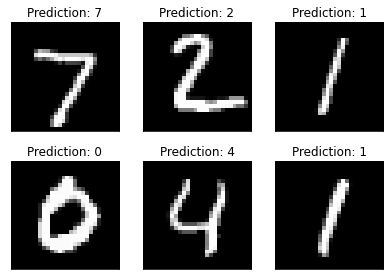

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    out = hypernetwork(inp=[test_set[i][0].to(hypernetwork.device)], has_aux=False)
    _, predicted = torch.max(out.detach(), -1)
    plt.subplot(2,3,i+1)
    plt.imshow(test_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(predicted.item()))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### LSTM Hypernetwork

In [43]:
from typing import Any, Dict, List, Optional, Tuple, Type, Union  # noqa
import torch.nn as nn

class LSTMHypernetwork(TorchHyperNetwork):
    def __init__(
        self,
        target_network: nn.Module,
        num_target_parameters: Optional[int] = None,
        embedding_dim: int = 100,
        num_embeddings: int = 3,
        hidden_dim: Optional[int] = None,
        *args, **kwargs
    ):
        super().__init__(
                    target_network = target_network,
                    num_target_parameters = num_target_parameters,
                    embedding_dim = embedding_dim,
                    num_embeddings = num_embeddings,
                    hidden_dim = hidden_dim,
                )

    def make_embedding(self):
        embedding = nn.Parameter(torch.randn(1, self.embedding_dim).to(self.device))
        return embedding

    def make_weight_generator(self):
        return nn.GRUCell(self.embedding_dim, self.hidden_dim)

    def generate_params(
        self, inp = []
    ) -> Tuple[torch.Tensor, Dict[str, Any]]:
        embedding = self.embedding
        hidden = torch.zeros(1, self.hidden_dim, device=self.device)
        output = []
        for _ in range(self.num_embeddings):
            hidden = self.weight_generator(embedding, hidden)
            output.append(hidden)
        return torch.stack(output).view(-1), {}


In [49]:
hypernetwork = LSTMHypernetwork.from_target(
    torch_target_network,
    embedding_dim=8,
    num_embeddings=7000
)

In [50]:
pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
pytorch_total_params

800

In [53]:
hypernetwork(inp=[torch.zeros((1,1,28,28), device=hypernetwork.device)])

tensor([[ 0.0585, -0.3283,  0.7292, -0.5671, -0.0905, -0.7228, -0.0016, -0.0040,
         -0.3661,  0.2521]], device='cuda:0', grad_fn=<ViewBackward0>)

In [51]:
device = torch.device('cuda')
hypernetwork = hypernetwork.to(device)

In [56]:
len(train_set)

60000

In [59]:
np.random.randint(0,100, 5)

array([67, 74, 83, 90, 54])

In [61]:
def random_sample(dataset, num_samples:int = 1):
    length = len(dataset)
    random_indices = np.random.randint(0,length, num_samples)
    return [dataset[idx] for idx in random_indices]

In [70]:
import tqdm
import numpy as np

num_samples = 1

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=32,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=32,
                shuffle=False)

optimizer = torch.optim.Adam(hypernetwork.parameters(), lr=0.001)
bar = tqdm.tqdm(np.arange(1000))

for i in bar:

    train_loss = []
    samples = random_sample(train_set, num_samples)
    for sample in samples:
        x = sample[0].view(1, 1, 28, 28).to(hypernetwork.device)
        target = torch.tensor(sample[1]).view(1,).to(hypernetwork.device)
        optimizer.zero_grad()
        out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        loss =  torch.nn.functional.cross_entropy(out.to(hypernetwork.device), target.to(hypernetwork.device))
        print("SHIT")
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)
    num_correct = 0
    count = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        count += x.size(0)
        with torch.no_grad():
            out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
            _, predicted = torch.max(out.detach(), -1)
        num_correct += (predicted.detach().cpu() == target.data).sum()
    accuracy = num_correct / count
    bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))


  0%|          | 0/1000 [00:00<?, ?it/s]

SHIT


Loss: 2.03393292427063, Test Acc: 0.10329999774694443:   0%|          | 1/1000 [01:34<26:19:02, 94.84s/it]

SHIT


Loss: 2.2978427410125732, Test Acc: 0.10320000350475311:   0%|          | 2/1000 [03:08<26:02:35, 93.94s/it]

SHIT


Loss: 2.2978427410125732, Test Acc: 0.10320000350475311:   0%|          | 2/1000 [03:43<31:00:24, 111.85s/it]


KeyboardInterrupt: 

## Jax

In [ ]:
# uncomment this to enable jax gpu preallocation, might lead to memory issues

import os
import jax
import jax.numpy as jnp

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [ ]:
import flax.linen as linen

In [ ]:
class JaxMNISTConvNet(linen.Module):

    @linen.compact
    def __call__(self, x):
        x = linen.Conv(64, kernel_size=(3,3), strides=2, padding="VALID")(x)
        x = linen.relu(x)
        x = linen.Conv(64, kernel_size=(3,3), strides=2, padding="VALID")(x)
        x = linen.relu(x)
        x = linen.Conv(64, kernel_size=(3,3), strides=2, padding="VALID")(x)
        x = linen.relu(x)
        x = linen.Conv(10, kernel_size=(2,2), strides=2, padding="VALID")(x)
        x = x.reshape(x.shape[0], -1)
        x = linen.log_softmax(x)
        return x

In [ ]:
jax_target_network = JaxMNISTConvNet()

In [ ]:
from hypernn.jax.utils import count_jax_params

count_jax_params(jax_target_network, inputs=[jnp.zeros((64,64,1))])

#### Simple Jax Hypernetwork

In [ ]:
from typing import Optional, Any, Dict

from hypernn.jax.embedding_module import FlaxEmbeddingModule
from hypernn.jax.weight_generator import FlaxWeightGenerator
from hypernn.jax.hypernet import FlaxHyperNetwork


class CustomFlaxEmbeddingModule(FlaxEmbeddingModule):
    def setup(self):
        self.embedding = linen.Embed(self.num_embeddings, self.embedding_dim)

    def __call__(self, inp: Optional[Any] = None):
        indices = jnp.arange(0, self.num_embeddings)
        return self.embedding(indices), {}

class CustomFlaxWeightGenerator(FlaxWeightGenerator):
    def setup(self):
        self.dense1 = linen.Dense(32)
        self.dense2 = linen.Dense(self.hidden_dim, use_bias=False)

    def __call__(self, embedding, inp: Optional[Any] = None):
        x = self.dense1(embedding)
        x = linen.tanh(x)
        x = self.dense2(x)
        return x.reshape(-1), {}


### Making hypernetwork with `embedding_dim = 4` and `num_embeddings = 1024`

In [ ]:
jax_hyper = FlaxHyperNetwork.from_target(
    target_network=jax_target_network,
    inputs=[jnp.zeros((28,28,1))],
    embedding_module=CustomFlaxEmbeddingModule,
    weight_generator=CustomFlaxWeightGenerator,
    embedding_dim = 4,
    num_embeddings = 1024
)

In [ ]:
count_jax_params(jax_hyper, inputs=[[jnp.zeros((28,28,1))]])

### Training MNIST

#### Creating train state

In [ ]:
import optax
from flax.training import train_state  # Useful dataclass to keep train state

def create_hyper_train_state(rng, model, learning_rate):
    """Creates initial `TrainState`."""
    params = model.init(rng, [jnp.zeros((28,28,1))])['params']
    tx = optax.chain(
        optax.adam(learning_rate)
    )
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx
    )

#### Update step

In [ ]:
def cross_entropy_loss(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [ ]:
import functools

@jax.jit
def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

@functools.partial(jax.jit, static_argnames=('apply_fn'))
def train_step(apply_fn, state, x, targets):
    """Train for a single step."""
    def loss_fn(params):
        logits = apply_fn({'params': params}, inp=[x], has_aux=False)
        loss = cross_entropy_loss(logits=logits, labels=targets)
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=targets)
    return state, metrics

In [ ]:
import tqdm
import numpy as np
from einops import rearrange

bar = tqdm.tqdm(np.arange(1000))

rng = jax.random.PRNGKey(0)
state = create_hyper_train_state(rng, jax_hyper, 0.0002)

for i in bar:

    train_loss = []
    for batch_idx, (x, target) in enumerate(train_loader):
        x = rearrange(jnp.array(x.numpy()), 'b c w h -> b w h c')
        target = jnp.array(target.numpy())

        state, metrics = train_step(jax_hyper.apply, state, x, target)
        loss = metrics["loss"]
        # optimizer.zero_grad()
        # out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        # loss =  torch.nn.functional.cross_entropy(out.to(hypernetwork.device), target.to(hypernetwork.device))
        # loss.backward()
        # optimizer.step()

        train_loss.append(loss.item())

    avg_loss = np.mean(train_loss)
    num_correct = 0
    count = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        x = rearrange(jnp.array(x.numpy()), 'b c w h -> b w h c')
        count += x.shape[0]
        logits = jax_hyper.apply({"params":state.params}, inp=[x], has_aux=False)
        # with torch.no_grad():
        #     out = hypernetwork(inp=[x.to(hypernetwork.device)], has_aux=False)
        #     _, predicted = torch.max(out.detach(), -1)
        num_correct += jnp.sum(jnp.argmax(logits, -1) == target.numpy())
    accuracy = num_correct / count
    bar.set_description("Loss: {}, Test Acc: {}".format(avg_loss, accuracy))


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    out = hypernetwork(inp=[test_set[i][0].to(hypernetwork.device)], has_aux=False)
    _, predicted = torch.max(out.detach(), -1)
    plt.subplot(2,3,i+1)
    plt.imshow(test_set[i][0].detach().numpy().squeeze(), cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(predicted.item()))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()